Big Data Bowl 2025 - Passing Play Predictive Analysis
---
by Amelia Bademosi

01/06/2024
## Introduction
Understanding the dynamics of player movements and their impact on play outcomes is crucial for gaining a competitive edge. My project leverages advanced NFL tracking data to analyze spatial awareness, decision-making, and predictive factors that influence the success of passing plays. Using data from a Week 1 game between the Philadelphia Eagles and Detroit Lions, I aim to introduce innovative metrics and models that uncover actionable insights. By focusing on player positioning, zone control, and pre-snap dynamics, this analysis contributes to the growing field of football analytics, providing tools to better understand and optimize on-field performance.

## Description of Project
My analysis seeks to answer critical questions about NFL passing play outcomes by utilizing player tracking data. It is divided into three core components:
<ul>
  <li><b>Visualizing Player Movements and Spatial Control:</b> Visualizations play a crucial role in understanding how players move and interact on the field. By mapping their trajectories and pre-snap alignments, this project identifies gaps in defensive coverage, highlights offensive strategies, and pinpoints mismatches. These visualizations provide a foundation for further analysis by offering a clear representation of player dynamics during specific plays.</li>

  <li><b>Introducing a Novel Zone Control Metric:</b> To evaluate spatial dominance, the project uses Voronoi diagrams, which partition the field into zones controlled by each player based on their positions. This innovative metric provides a quantitative measure of how effectively players control their respective areas, offering insights into defensive structure and offensive positioning. By analyzing changes in zone control over time, the project uncovers key factors contributing to successful or unsuccessful plays.</li>

  <li><b>Predicting Passing Play Outcomes:</b> Predictive modeling is applied to determine how pre-snap movements, defensive pressure, and other factors impact play outcomes. By incorporating features such as “yardsToGo,” “offenseFormation,” “receiverAlignment,” and “timeLeft,” the model attempts to forecast whether a passing play will succeed or fail. This analysis helps identify patterns and trends that teams can use to optimize their strategies and improve decision-making.</li>
</ul>

By combining advanced visualizations,innovative metrics, and data-driven predictions, this project showcases the power of tracking data in uncovering actionable insights that can benefit teams, analysts, and the broader football community.

In [1]:
install.packages("/kaggle/input/ggvoronoi2", repos = NULL, type = "source")
mypath <- "/kaggle/input/nflbdb2025"


# importing packages for downloading data and field animation
source('/kaggle/input/sharedcode/SharedCode.R')
source('/kaggle/input/gg-field/gg_field.R')

# remove unused functions, data frames, and values throughout to use less memory
rm(check_playId_gameId, load_data_for_all_weeks, load_data_for_specified_weeks,
   motion_stats_single_week,visualize_single_frame,visualize_single_play,
   red_zone_plays,remove_frames_before_lineset,include_voronoi_polygons_and_area)

load_packages(c("data.table", "dplyr", "ggplot2", "ggalt", "gifski", "purrr","sf",
                "gganimate","hms", "lubridate", "deldir","ggvoronoi", "furrr", "psych","IRdisplay"))
# ----------------------- Making data frames --------------------------------
df <- load_data_for_one_week(directory = mypath, week = 1, merge = TRUE)
# create a data frame that contains play information for pre-snap frames
t1 <- df %>% filter(passResult != "", frameType == "BEFORE_SNAP",
         displayName !="football") %>%
  select(gameId, playId, frameId, nflId,  displayName, jerseyNumber, possessionTeam, club, passResult, 
         frameType, time, gameClock, quarter, x, y, s, a, dis, o, dir, yardsToGo, down, offenseFormation, receiverAlignment) %>%
  group_by(gameId,playId) %>% 
  data.frame()

# add 'success' column that define a successful play as a complete pass
t1$success <- ifelse(t1$passResult == "C", 1,0)

t2 <- t1 %>%
  filter(possessionTeam =="PHI")%>%
  group_by(playId, nflId) %>%  
  arrange(frameId) %>%
  mutate(gc_seconds = as.numeric(substring(gameClock, 4, 5)) + (
           as.numeric(substring(gameClock, 1, 2))*60),
          #creating variable for time left in game
         timeLeft = (case_when(
           quarter == 1 ~ gc_seconds + 2700,
           quarter == 2 ~ gc_seconds + 1800,
           quarter == 3 ~ gc_seconds + 900, 
           quarter == 4 ~ gc_seconds)),
         clock = hms::as_hms(time),
         seconds = as.numeric(seconds(clock)),
         time_diff = seconds - lag(seconds),
         # Calculate dx, dy, vx, vy, and change in direction 
         dy = ifelse(y == lag(y), NA, y- lag(y)),
         dx = ifelse(x == lag(x), NA, x- lag(x)),
         vx = dx / time_diff,
         vy = dy / time_diff,
         d_direction = atan2(dy, dx),
         d_direction = ifelse(is.na(d_direction), 0, d_direction),
         vx = ifelse(is.na(vx), 0,vx), vy = ifelse(is.na(vy), 0,vy),
         dx = ifelse(is.na(dx), 0,dx), dy = ifelse(is.na(dy), 0,dy)) %>% 
  data.frame()

rm(df,t1)
# ------------------- making clusters of movement types ---------------------
# subset containing all the types of movement before the snap to make clusters of types of movement
movement_features <- t2 %>% select(nflId, s, dir, d_direction, dx,dy, vx, vy)%>% data.frame()

# making 3 clusters
kmeans_result <- kmeans(movement_features, centers = 3) 
movement_features$cluster <- kmeans_result$cluster
t2$cluster <- kmeans_result$cluster

rm(kmeans_result, movement_features)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#### <b>Visualization 1</b>: An animation of an example play 
To begin the analysis, I focus on Play 3842 from Week 1 of the Philadelphia Eagles vs. Detroit Lions game. This play serves as an example for illustrating player movements and interactions.

The animation shows players aligning at the line of scrimmage before the snap, providing a clear visualization of their positions, pre-snap movements, and initial play dynamics.

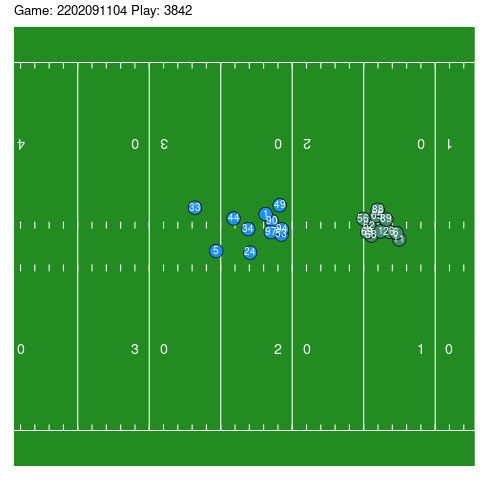

In [2]:
t3 <- t2%>% filter(playId == 3842)%>% data.frame()

# visualization of play 3842
anim1 <- ggplot(data = t3, aes(x = x, y = y), color=club, fill=club) +
  scale_size_manual(values = c(6, 6), guide = "none") +
  scale_shape_manual(values = c(21, 21), guide = "none") +
  scale_fill_manual(values = c( "dodgerblue1" , "aquamarine4"),na.value = NA,guide="none") + 
  scale_colour_manual(values = c("black","black"),na.value = NA,guide="none") + 
  gg_field(yardmin = max(-5,min(t3$x)-5), yardmax = min(max(t3$x)+5, 125) ) +
  geom_point(aes(shape = club, colour = club, size = club, fill = club))+
  geom_text(data = t3,aes(x=x, y=y,label = jerseyNumber), colour = "white", size = 3.5, vjust = 0.36 )+
  labs(title = "Game: 2202091104 Play: 3842") +
  transition_time(frameId)

anim_gif1 <- animate(anim1, nframes = 100, fps = 10, renderer = gifski_renderer())
anim_save("animation1.gif", animation = anim_gif1)
display_png(file = "animation1.gif")

#### <b>Visualization 2</b>: An animation of the different types of movement in the sample play
To categorize player movements during the play, I clustered the tracking data into three distinct movement profiles. Players in the visualization are color-coded by their assigned clusters, revealing patterns and dynamics.

Cluster Breakdown:
<ul>
  <li>Cluster 1 - Players often exhibit moderate forward speeds. Simple or stable facing direction. Minimal lateral movement, especially early in the play.</li>

  <li>Cluster 2 - Players frequently remain at very low speeds or stationary-like conditions. Minimal directional changes, often associated with positioning or pre-snap alignment.</li>

  <li>Cluster 3 -  Players display more complex directional changes. Non-zero velocities in both x and y directions. Highly dynamic movement patterns, such as sharp cuts or reactive movements.</li>
</ul>

This clustering provides a framework to identify roles and behaviors during the play, such as which players are actively moving into position, holding their zones, or reacting dynamically to the play's evolution.

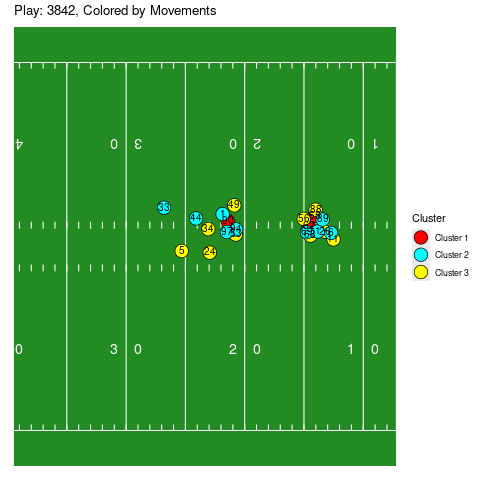

In [3]:
anim2 <- ggplot(data = t3, aes(x = x, y = y)) +
  gg_field(yardmin = max(-5, min(t3$x) - 5), yardmax = min(max(t3$x) + 5, 125)) +
  geom_point(aes(fill = as.factor(cluster)), size = 6, shape = 21) + 
  scale_shape_manual(values = c(21, 21), guide = "none") +
  scale_fill_manual(values = c("red", "cyan", "yellow"), name = "Cluster",
                    labels = c("Cluster 1", "Cluster 2", "Cluster 3")) + 
  scale_color_manual(values = c("red", "cyan", "yellow"), guide = "none") + 
  geom_text(data = t3, aes(x=x, y=y, label = jerseyNumber), colour = "black", size = 3.5, vjust = 0.36)+
  labs(title = "Play: 3842, Colored by Movements") +
  transition_time(frameId)
anim_gif2 <- animate(anim2, nframes = 100, fps = 10, renderer = gifski_renderer())
anim_save("animation2.gif", animation = anim_gif2)
display_png(file = "animation2.gif")



In this section, I analyze Play 3842 using Voronoi diagrams to visualize the zones controlled by each player on the field. These zones represent areas of influence based on the player's proximity to different points on the field.

To better understand team dynamics and spatial control, the Voronoi zones are separated by team:
<ul>
  <li>The offensive players' zones (in green) represent the areas they control while advancing the ball or positioning for a play.</li>
  <li>The defensive players' zones (in blue) reflect areas they aim to defend or contain to prevent offensive gains.</li>
</ul>

By comparing these zones, I highlight instances of zone overlap between the two teams. Overlap zones are critical for understanding areas where defensive players encroach on offensive zones and where one team’s zone control is dominant, potentially leading to successful plays or breakdowns.

In [4]:
# ----------------------------- Voronoi polygons -------------------------------

# Create Voronoi diagrams with a dynamic bounding box
create_voronoi <- function(team_data) {
  results <- team_data %>%
    group_by(playId, frameId, club) %>%
    group_split() %>%
    lapply(function(data) {
      # Calculate bounding box with 5-yard buffer
      x_min <- min(data$x) - 2
      x_max <- max(data$x) + 2
      y_min <- min(data$y) - 2
      y_max <- max(data$y) + 2
      
      # Create Voronoi tessellation within this bounding box
      voronoi <- deldir(data$x, data$y, rw = c(x_min, x_max, y_min, y_max), 
                        sort = TRUE, id = data$nflId)
      tiles <- voronoi$dirsgs
      tiles$frameId <- unique(data$frameId)
      tiles$playId <- unique(data$playId)
      
      # Create a data frame for the bounding box polygon
      box_coords <- data.frame(
        playId = unique(data$playId),
        frameId = unique(data$frameId),
        x = c(x_min, x_max, x_max, x_min, x_min),
        y = c(y_min, y_min, y_max, y_max, y_min)  )
      list(voronoi_tiles = tiles, bounding_box = box_coords)  })
  voronoi_tiles <- do.call(rbind, lapply(results, `[[`, "voronoi_tiles"))
  bounding_boxes <- do.call(rbind, lapply(results, `[[`, "bounding_box"))
  list(voronoi_tiles = voronoi_tiles, bounding_boxes = bounding_boxes)  }

# team 1 is offense, team 2 is defense
team_1 <- t2 %>%filter(club == "PHI")%>%data.frame()
team_2 <- t2 %>%filter(club == "DET")%>%data.frame()

team_1_results <- create_voronoi(team_1)
team_2_results <- create_voronoi(team_2)

# Access the results
voronoi_frames1 <- team_1_results$voronoi_tiles
bounding_boxes1 <- team_1_results$bounding_boxes

voronoi_frames2 <- team_2_results$voronoi_tiles
bounding_boxes2 <- team_2_results$bounding_boxes

# making voronoi polygons allows the area of each players zone to be measured
create_voronoi_polygons <- function(data, bounds) {
  # Check if we have at least 2 points
  if (nrow(data) < 2) {return(st_sf(player=character(0), geometry=st_sfc()))}
  vor <- deldir(data$x, data$y, rw = bounds, sort = TRUE)
  tiles <- tile.list(vor)
  if (length(tiles) != nrow(data)) {return(st_sf(player=character(0), geometry=st_sfc()))}
  polygons <- lapply(tiles, function(tile) {coords <- cbind(tile$x, tile$y)
  if (!all(coords[1, ] == coords[nrow(coords), ])) {coords <- rbind(coords, coords[1, ])}
  st_polygon(list(coords))})
  polygons_sf <- st_sfc(polygons, crs = 4326) %>%st_sf(player = data$displayName, geometry = .)
  return(polygons_sf)}

# Now create the dynamic bounding box for each teams zones 
x_min <- min(bounding_boxes1$x)
x_max <- max(bounding_boxes1$x)
y_min <- min(bounding_boxes1$y)
y_max <- max(bounding_boxes1$y)
bounds1 <- c(x_min, x_max, y_min, y_max)
team_1_unique <- team_1 %>% distinct(x, y, .keep_all = TRUE)
team_1_polygons <- create_voronoi_polygons(team_1_unique, bounds1)

x_min <- min(bounding_boxes2$x)
x_max <- max(bounding_boxes2$x)
y_min <- min(bounding_boxes2$y)
y_max <- max(bounding_boxes2$y)

bounds2 <- c(x_min, x_max, y_min, y_max)
team_2_unique <- team_2 %>% distinct(x, y, .keep_all = TRUE)
team_2_polygons <- create_voronoi_polygons(team_2_unique, bounds2)

#### Calculate area of each player's Voronoi zone on Team 1
team_1_unique$geometry <- team_1_polygons$geometry
team_1_unique <- team_1_unique %>%mutate(area = st_area(geometry))%>% data.frame()
team_1_polygons <- team_1_unique%>% data.frame()

team_2_unique$geometry <- team_2_polygons$geometry
team_2_unique <- team_2_unique %>% mutate(area = st_area(geometry))%>% data.frame
team_2_polygons <- team_2_unique%>%  data.frame

# A custom CRS treating units as yards in a simple planar projection
team_1_polygons <- st_as_sf(team_1_polygons,  crs = 4326)
team_2_polygons <- st_as_sf(team_2_polygons,  crs = 4326)
team_1_polygons <- st_simplify(team_1_polygons, dTolerance = 0.1)
team_2_polygons <- st_simplify(team_2_polygons, dTolerance = 0.1)

rm(voronoi_frames1, voronoi_frames2, bounds1, bounds2,x_min, x_max, y_min, y_max,
   team_1_unique, team_2_unique, team_1_results, team_2_results, bounding_boxes1, bounding_boxes2)



#### <b>Visualization 3</b>: An animation of the player zones
The animation illustrates how these zones evolve throughout the play before the snap and sets the groundwork for calculating the Zone Control Metric, which quantifies the degree of overlap and its impact on the play's outcome.

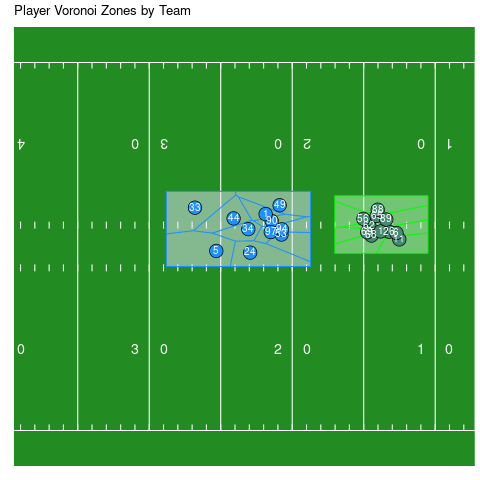

In [5]:

t3_1 <- t3 %>% filter(club == "PHI")%>%  data.frame()
t3_2 <- t3 %>% filter(club == "DET")%>% data.frame()
team_results1 <- create_voronoi(t3_1)
team_results2 <- create_voronoi(t3_2)

voronoi_t3_1  <- team_results1$voronoi_tiles
boxes_t3_1 <- team_results1$bounding_boxes
voronoi_t3_2 <- team_results2$voronoi_tiles
boxes_t3_2 <- team_results2$bounding_boxes

anim3 <- ggplot(data = t3, aes(x = x, y = y)) +
  gg_field(yardmin = max(-5,min(t3$x)-5), yardmax = min(max(t3$x)+5, 125)) +
  geom_polygon(data = boxes_t3_1,aes(x = x, y = y, group = frameId), 
               fill = "darkseagreen1", color = "green", alpha = .5)+
  geom_segment(data = voronoi_t3_1, aes(x = x1, y = y1, xend = x2, yend = y2), color = "green")+
  geom_polygon(data = boxes_t3_2,aes(x = x, y = y, group = frameId),
               fill = "lavender", color = "dodgerblue1", alpha =.5)+
  geom_segment(data = voronoi_t3_2,aes(x = x1, y = y1, xend = x2, yend = y2), color = "dodgerblue1") +
  geom_point(aes(fill = as.factor(club)), size = 6, shape = 21) +
  scale_shape_manual(values = c(21, 21), guide = "none") +
  scale_fill_manual(values = c( "dodgerblue1" , "aquamarine4"),na.value = NA,guide="none") + 
  scale_colour_manual(values = c("black","black"),na.value = NA,guide="none") + 
  geom_text(data = t3, aes(x=x, y=y,label = jerseyNumber), colour = "white", size = 3.5, vjust = 0.36 )+
  labs(title = "Player Voronoi Zones by Team") +
  transition_time(frameId)
anim_gif3 <- animate(anim3, nframes = 100, fps = 10, renderer = gifski_renderer())
anim_save("animation3.gif", animation = anim_gif3)
display_png(file = "animation3.gif")


## Zone Control Metric

The Zone Control Metric is a key tool for quantifying how effectively an offensive player controls their assigned area during a play. This metric leverages Voronoi diagrams, which divide the football field into dynamic zones. Each zone represents the region closest to a specific player at any given moment. As players move, their zones shift, providing a real-time representation of spatial control. These zones help evaluate how offensive players create or maintain space relative to their defensive counterparts.

Voronoi diagrams are essential to this analysis, as they dynamically partition the field based on player positioning. Each player's Voronoi zone represents the area they influence most, allowing for precise measurements of spatial control and contested areas. By monitoring changes in these zones throughout a play, the metric reveals how defensive pressure shifts and how offensive players exploit available space.

The Zone Control Metric is calculated using the following formula:

$$
\text{Zone Control Percentage} = \frac{100}{1 + \text{Number of Defenders in Zone}}
$$
 
This formula accounts for the number of defensive players present in the offensive player’s zone, offering a straightforward measure of spatial dominance.

The Zone Control Metric provides a standardized way to interpret spatial dynamics during a play. Higher zone control percentage indicates that fewer defenders are present within the offensive player's zone. This suggests greater control, providing the offensive player with more freedom to execute plays and reducing the likelihood of defensive disruption. Lower zone control percentage reflects a higher number of defenders within the zone which limits the offensive player’s opportunities and may force hurried or sub-optimal decisions.

In [6]:
# ------------------------- Create Zone Control Metric -------------------------

# Create grid zones
zones <- st_make_grid(st_bbox(team_1_polygons), cellsize = 5) %>% st_as_sf()

# Count players in each zone
team_1_density <- st_join( team_1_polygons, zones) %>% 
  group_by(geometry) %>% summarise(players = n())
team_2_density <- st_join( team_2_polygons, zones) %>% 
  group_by(geometry) %>% summarise(players = n())

team_1_polygons$zone_density <- team_1_density$players
team_2_polygons$zone_density <- team_2_density$players

control_metric <- team_1_polygons %>%
  mutate(defenders_in_zone = zone_density - 1, 
         control_of_zone = 100/ (1+defenders_in_zone))

team_1_polygons$control_of_zone <- control_metric$control_of_zone
team_2_polygons$control_of_zone <- NA

team_1 <- team_1 %>%
  left_join(team_1_polygons %>% select(x, y, control_of_zone), by = c("x", "y"))
team_2 <- team_2 %>%
  left_join(team_2_polygons %>% select(x, y, control_of_zone), by = c("x", "y"))

t4 <- rbind(team_1,team_2)

rm(team_2_polygons,team_1_polygons,team_1_density,team_2_density)


## Predictive Model 
First, I split the dataset into training and testing subsets to build and evaluate the model. Twelve plays were reserved for testing, while the remaining twenty-four plays were used for training. 

To predict the success of plays, I developed a logistic regression model with the following explanatory variables: 

- **X_1**: Yards to go in the down  
- **X_2**: Time left in the game  
- **X_3**: Zone control percentage  
- **X_4**: Player movement cluster

This model evaluates how player behavior, spatial control, and overall game pressure contribute to the probability of a play’s success. 

The logistic regression equation using the coefficients estimated from the model can be represented as follows:

$$
\log \left( \frac{P(\text{success})}{1 - P(\text{success})} \right) = 1.378 - 0.07589 \cdot X_1 - 0.0005258 \cdot X_2 - 0.001456 \cdot X_3 + 0.003569 \cdot X_4
$$

To calculate the probability of success, P(success), use the logistic function:

$$
P(\text{success}) = \frac{1}{1 + e^{-(1.378 - 0.07589 \cdot X_1 - 0.0005258 \cdot X_2 - 0.001456 \cdot X_3 + 0.003569 \cdot X_4)}}
$$

The model outputs a probability of success for each frame. Play predictions are classified as successful (Y = 1) or unsuccessful (Y = 0) based on whether the predicted probability P(success) exceeds a threshold of 0.5.


In [7]:
# ------------------------------ Predictive model ------------------------------
# training and testing data sets 
test_data <- t4 %>%
  filter(playId %in% c( 390, 462, 558,689,777,803, 910,1183,1228, 2130, 2190, 3148)) %>%
  group_by(playId) %>% data.frame()

training_data <- t4 %>% 
  filter(playId %notin%  c( 390, 462, 558,689,777,803, 910,1183,1228, 2130, 2190, 3148))%>%
  group_by(playId) %>% data.frame()

# Fit logistic regression model
logistic_model <- glm(success ~  yardsToGo + timeLeft + control_of_zone + cluster, 
                      data = training_data, 
                      family = binomial)
summary(logistic_model)

# Predict on test data
test_data$predicted_prob <- predict(logistic_model, test_data, type = "response")
test_data$predicted_class <- ifelse(test_data$predicted_prob > 0.5, 1, 0)

#### Evaluate model performance

# predictions by frame
confusion_matrix <- table(test_data$success, test_data$predicted_class)
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
print(paste("Frame-Level Accuracy:", accuracy))

# Aggregate probabilities by play (mean probability)
play_predictions <- test_data %>%
  group_by(playId) %>%
  summarise(overall_prob = mean(predicted_prob, na.rm = TRUE),
            success = first(success)) 

play_predictions <- play_predictions %>%
  mutate(predicted_success = ifelse(overall_prob > 0.5, 1, 0))

# Confusion matrix for play-level predictions
confusion_matrix_play <- table(play_predictions$success,play_predictions$predicted_success)
accuracy_play <- sum(diag(confusion_matrix_play)) / sum(confusion_matrix_play)
print(paste("Play-Level Accuracy:", accuracy_play))



Call:
glm(formula = success ~ yardsToGo + timeLeft + control_of_zone + 
    cluster, family = binomial, data = training_data)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.383e+00  8.206e-02  16.857   <2e-16 ***
yardsToGo       -7.590e-02  3.444e-03 -22.037   <2e-16 ***
timeLeft        -5.258e-04  1.426e-05 -36.884   <2e-16 ***
control_of_zone -1.450e-03  6.378e-04  -2.274    0.023 *  
cluster          1.419e-04  1.276e-02   0.011    0.991    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 63866  on 46606  degrees of freedom
Residual deviance: 62412  on 46602  degrees of freedom
  (46607 observations deleted due to missingness)
AIC: 62422

Number of Fisher Scoring iterations: 4


[1] "Frame-Level Accuracy: 0.690565274547477"


[1] "Play-Level Accuracy: 0.583333333333333"


#### <b>Visualization 4</b>: A heatmap of the counts in the confusion matrix for frame-level predictions

The confusion matrix for frame-by-frame predictions shows:
<ul>
<li>True Negatives (11660): Correctly predicted unsuccessful plays.</li>
<li>True Positives (1998): Correctly predicted successful plays.</li>
<li>False Negatives (6120): Missed successful plays predicted as unsuccessful.</li>
<li>False Positives (0): Predicted unsuccessful plays as successful.</li>
</ul>
Accuracy: 69.05%

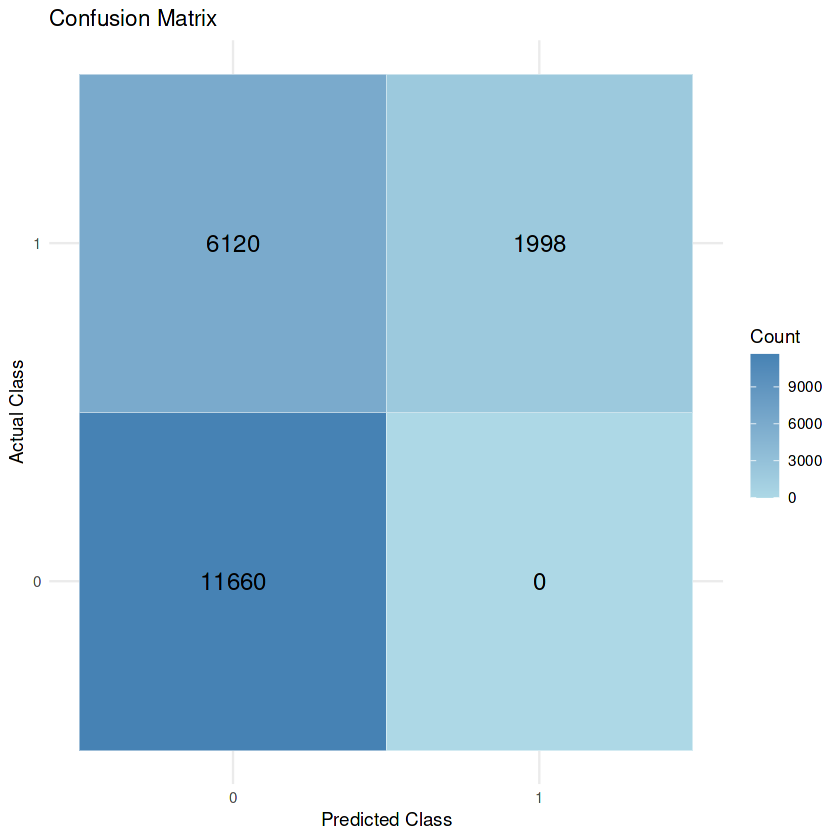

In [8]:

# Convert confusion matrix to a data frame for ggplot
confusion_long <- as.data.frame(as.table(confusion_matrix))
colnames(confusion_long) <- c("Actual", "Predicted", "Count")

# Plot confusion matrix as a heatmap
ggplot(confusion_long, aes(x = Predicted, y = Actual, fill = Count)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Count), color = "black", size = 5) +
  scale_fill_gradient(low = "lightblue", high = "steelblue") +
  labs(title = "Confusion Matrix", x = "Predicted Class", y = "Actual Class") +
  theme_minimal()



#### <b>Visualization 5</b>: A heatmap of the counts in the confusion matrix for play-level predictions

Predictions were aggregated by play, and the confusion matrix showed
6 correctly classified plays as unsuccessful, 1 correctly classified as successful, and 5 misclassified as unsuccessful plays, leading to an accuracy of 58.33%.

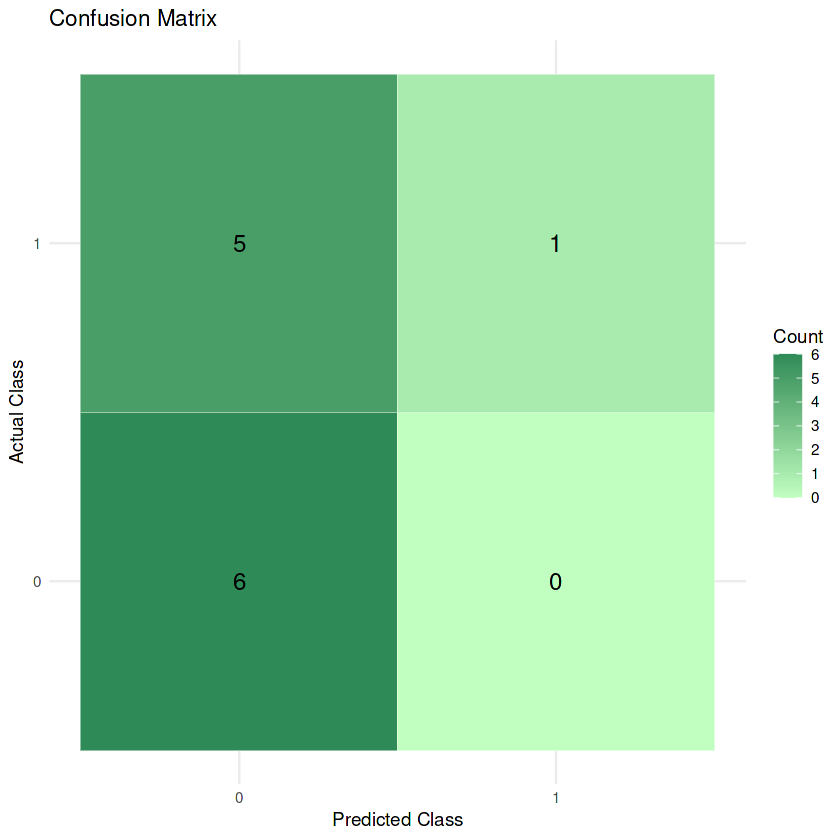

In [9]:
# for play level predictions
confusion_play <- as.data.frame(as.table(confusion_matrix_play))
colnames(confusion_play) <- c("Actual", "Predicted", "Count")

ggplot(confusion_play, aes(x = Predicted, y = Actual, fill = Count)) +
  geom_tile(color = "white") +
  geom_text(aes(label = Count), color = "black", size = 5) +
  scale_fill_gradient(low = "darkseagreen1", high = "seagreen") +
  labs(title = "Confusion Matrix", x = "Predicted Class", y = "Actual Class") +
  theme_minimal()



## Conclusion
My model demonstrates strong performance in predicting unsuccessful passes, both by frame and by play. While the overall accuracy is moderate and the variables used are statistically significant, the model struggles to accurately predict successful plays. Potential improvements include incorporating additional features, fine-tuning thresholds, and expanding the training and testing datasets to better capture the dynamics of successful passes. Despite the need for accuracy enhancements, the metrics and movement categorization I developed provide valuable insights into pre-snap factors influencing passing plays, offering actionable information for further analysis and strategic applications.


If you have any questions, please feel free to email me at <a href="mailto:abademosi@loyola.edu">abademosi@loyola.edu</a>. Also, feel free to check out my RPubs for other NFL analyses I've done in class! <a href="url">https://rpubs.com/abademosi</a>

Go Birds!